<a href="https://colab.research.google.com/github/BachiLi/A-Tour-of-Computer-Animation/blob/main/A_Tour_of_Computer_Animation_3_Time_Integration_and_Stability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

So far we either solve a differential equation analytically, or we solve it using Euler method. In practice, these two options are seldomly used for computer animation. There is a wide variety of numerical differential equation solvers, or numerical time integrators, which we will introduce in this chapter.

Typically, numerical time integrators make trade-offs in the following criteria:
- efficiency
- accuracy
- stability

The first two are easy to understand: you can do more computation to achieve better accuracy, but that makes things slower. However, the notion of stability is less clear. Let's clarify this.

Firstly, the stability of an ODE is different from the stability of the numerical solver of the ODE. Let's explain the stability of an ODE first.

# (Linear) stability analysis of ODEs

We are going to first use a classical motion: [Hooke's law](https://en.wikipedia.org/wiki/Hooke%27s_law#For_linear_springs), to explain the idea of stability:

$\ddot{x} = -x$

This equation corresponds to the motion of a mass attached to a spring. $x=0$ if the mass is at the rest length, and when the offset $x$ is large, the spring applies a large force to pull the mass back, and vice versa. It has a simple closed-form solution:

$x(t) = x(0) \cos(t) + \dot{x}(0) \sin(t)$

Let's try to visualize this, just for fun.

In [1]:
import math
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

fps = 20

x0 = 1.0
v0 = 1.0
def x(t):
    return x0 * math.cos(t) + v0 * math.sin(t)

def visualize(x):
    fig = plt.figure()
    ax = plt.axes(xlim=(-2.1, 2.1), ylim=(-2.1, 2.1))
    point, = ax.plot([0], [0], 'g.', ms=20)
    plt.axis('off')

    def animate(i):
        t = i/fps
        point.set_data([x(t)], [0])
        return point,

    plt.close()
    return animation.FuncAnimation(fig, animate, frames=200, interval=fps, blit=True)

anim = visualize(x)
HTML(anim.to_html5_video())

A little bit boring, but this is actually the foundation of the *elastic simulation* which studies how to simulate object deformation. We study this simple motion because it is *linear* (it will hopefully be clear what this means later) and has a closed-form solution.

We analyze Hooke's law by first writing it as a first-order ODE system. You can do this to *any* higher-order ODEs. Just assign a set of new variables $g_n$ and set $\frac{d}{dt} g_n = \frac{d^{n+1} x(t)}{dt^{n+1}}$. In our case the Hooke's law becomes

$\dot{x} = v$

$\dot{v} = -x$

This is a *linear* first-order ODE. To see this, we can rewrite it as a matrix-vector multiplication.

$
\begin{bmatrix}
\dot{x} \\
\dot{v}
\end{bmatrix}
=
\begin{bmatrix}
 0 & 1 \\
-1 & 0
\end{bmatrix}
\begin{bmatrix}
x \\
v
\end{bmatrix}
$

We will see the implication of this linearity later.

A common technique for visualizing and analyzing the stability of an ODE and its solver is called the *phase flow* (the name phase comes from Hamiltonian mechanics. Maybe we will talk more about it in the future). Given an initial position $x(0)$ and velocity $v(0)$, we can plot their trajectory over time on a 2D plane with the horizontal axis being $x$ and vertical axis being $v$. Let's try to plot this: recall that $x(t) = x(0) \cos(t) + v(0) \sin(t)$, so $v(t) = v(0) \cos(t) - x(0) \sin(t)$.

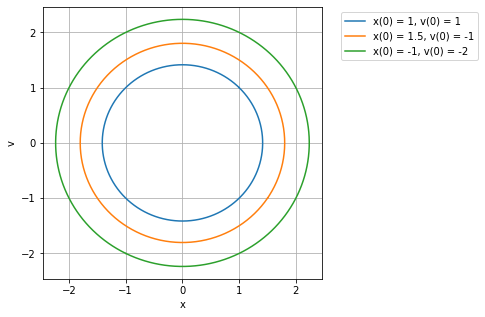

In [2]:
import numpy as np
# some samplings of t
t = np.arange(0.0, 2 * math.pi, 0.01)
# first flow: x(0) = 1, v(0) = 1
x1 = 1 * np.cos(t) + 1 * np.sin(t)
v1 = 1 * np.cos(t) - 1 * np.sin(t)
# second flow: x(0) = 1.5, v(0) = -1
x2 = 1.5 * np.cos(t) - 1 * np.sin(t)
v2 = -1 * np.cos(t) - 1.5 * np.sin(t)
# third flow: x(0) = -1, v(0) = -2
x3 = -1 * np.cos(t) - 2 * np.sin(t)
v3 = -2 * np.cos(t) + 1 * np.sin(t)

fig = plt.figure(figsize=(5, 5))
ax = plt.axes()
ax.plot(x1, v1, label = 'x(0) = 1, v(0) = 1')
ax.plot(x2, v2, label = 'x(0) = 1.5, v(0) = -1')
ax.plot(x3, v3, label = 'x(0) = -1, v(0) = -2')
ax.set(xlabel='x', ylabel='v')
ax.grid()
ax.legend(bbox_to_anchor=(1.05, 1))
plt.show()

You probably have noticed that the trajectories form a set of circles. We can actually see this from the perspective of energy conservation. For a physics system that conserves energy, we know from the last chapter that $\frac{1}{2} m \dot{x}^2 + U = \text{const}$. In this case, the potential energy $U$ is $-\frac{1}{2} m x^2$ (so $F = m \ddot{x} = \frac{d U}{d x} = -mx$), so we know that $\dot{x}^2 + x^2 = v^2 + x^2 = \text{const}$. In fact, in classical mechanics, for physics systems that conserve energies, their phase flow will be on a [level set](https://en.wikipedia.org/wiki/Level_set) of the energy function $E(x, v, t) = \frac{1}{2} m v^2 + U(x, v, t)$.

Not all level sets of the energy functions are circles, though. Let's look at a different, still linear ODEs $x'' = x$:

$
\begin{bmatrix}
\dot{x} \\
\dot{v}
\end{bmatrix}
=
\begin{bmatrix}
 0 & 1 \\
1 & 0
\end{bmatrix}
\begin{bmatrix}
x \\
v
\end{bmatrix}
$

The closed-form solution is $x(t) = \frac{x(0) + v(0)}{2} e^{t} + \frac{x(0) - v(0)}{2} e^{-t}$, and $v(t) = \frac{x(0) + v(0)}{2} e^{t} - \frac{x(0) - v(0)}{2} e^{-t}$. Let's plot its phase flow:

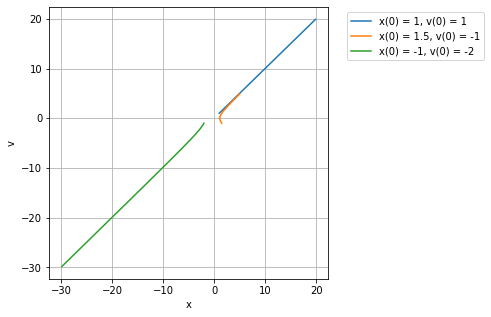

In [3]:
# some samplings of t
t = np.arange(0.0, 3, 0.01)
# first flow: x(0) = 1, v(0) = 1
x1 = 1 * np.exp(t)
v1 = 1 * np.exp(t)
# second flow: x(0) = 1.5, v(0) = -1
x2 = 0.25 * np.exp(t) + 1.25 * np.exp(-t)
v2 = 0.25 * np.exp(t) - 1.25 * np.exp(-t)
# third flow: x(0) = -1, v(0) = -2
x3 = -1.5 * np.exp(t) - 0.5 * np.exp(-t)
v3 = -1.5 * np.exp(t) + 0.5 * np.exp(-t)

fig = plt.figure(figsize=(5, 5))
ax = plt.axes()
ax.plot(x1, v1, label = 'x(0) = 1, v(0) = 1')
ax.plot(x2, v2, label = 'x(0) = 1.5, v(0) = -1')
ax.plot(x3, v3, label = 'x(0) = -1, v(0) = -2')
ax.set(xlabel='x', ylabel='v')
ax.grid()
ax.legend(bbox_to_anchor=(1.05, 1))
plt.show()

Clearly they are not bounded like the circle case (you can see this by noting that the energy is proportional to $v^2 - x^2 = \text{const}$). Further, they spiral *outside* from their initial positions, and go towards infinity.

Let's look at one more example with an ODE $\ddot{x} = - x - \dot{x}$. It is still linear:

$
\begin{bmatrix}
\dot{x} \\
\dot{v}
\end{bmatrix}
=
\begin{bmatrix}
 0 & 1 \\
-1 & -1
\end{bmatrix}
\begin{bmatrix}
x \\
v
\end{bmatrix}
$

The closed-form solution is 
$x(t) = e^{-\frac{t}{2}} \left( \frac{\sqrt{3}}{3} (x(0) + 2 \dot{x}(0)) \sin\left(\frac{\sqrt{3}}{2} t\right) + x(0) \cos\left(\frac{\sqrt{3}}{2} t\right) \right)$
and
$\dot{x}(t) = e^{-\frac{t}{2}} \left( -\frac{\sqrt{3}}{3} \left(2x(0) + \dot{x}(0) \right) \sin\left(\frac{\sqrt{3}}{2} t\right) + \dot{x}(0) \cos\left(\frac{\sqrt{3}}{2} t\right) \right)$

(we'll talk about an easier way to derive these later). 

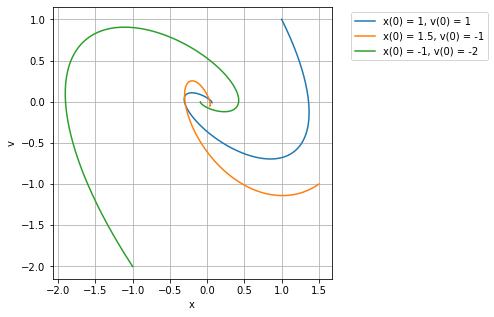

In [4]:
# some samplings of t
t = np.arange(0.0, 4 * math.pi / math.sqrt(3), 0.01)
def x(x0, v0):
    tt = (math.sqrt(3) / 2) * t
    xt = np.exp(-t/2) * ((np.sqrt(3) / 3) * (x0 + 2 * v0) * np.sin(t) + x0 * np.cos(tt))
    vt = np.exp(-t/2) * (-(np.sqrt(3) / 3) * (2 * x0 + v0) * np.sin(t) + v0 * np.cos(tt))
    return xt, vt

# first flow: x(0) = 1, v(0) = 1
x1, v1 = x(1, 1)
# second flow: x(0) = 1.5, v(0) = -1
x2, v2 = x(1.5, -1)
# third flow: x(0) = -1, v(0) = -2
x3, v3 = x(-1, -2)

fig = plt.figure(figsize=(5, 5))
ax = plt.axes()
ax.plot(x1, v1, label = 'x(0) = 1, v(0) = 1')
ax.plot(x2, v2, label = 'x(0) = 1.5, v(0) = -1')
ax.plot(x3, v3, label = 'x(0) = -1, v(0) = -2')
ax.set(xlabel='x', ylabel='v')
ax.grid()
ax.legend(bbox_to_anchor=(1.05, 1))
plt.show()

You'll see that they spiral *inside* towards (0, 0) from their initial positions and eventually stop at somewhere around it.

We've seen three kinds of different categories of ODE behaviors in these examples. The first example ($\ddot{x} = -x$) is periodic: it just keeps circulating around an orbit without ever converging to a point. The second example ($\ddot{x} = x$) is diverging: it grows to infinity as times go on. The third example ($\ddot{x} = - x - \dot{x}$) converges to a rest point after infinite time. 

The foundation of ODE stability analysis is established by [Lyapunov](https://en.wikipedia.org/wiki/Lyapunov_stability). We say the first category above is *stable*. The second is not stable. The third category is *stable* and globally *attractive* (it is *asymptoptically stable*). In general, if the trajectory in the limit does not go too far away from the initial state, the ODE is stable.

Why do we care about stability? Because we do not want an ODE solver to "explode". An unstable ODE solver, even if accuracte and efficient some times, can be annoying in many applications. 

As mentioned, the concept of ODE stability is different from the stability of the numerical ODE solvers. Let's try to plot the phase flow of the Euler method approximateion of the first ODE $\ddot{x} = -x$.

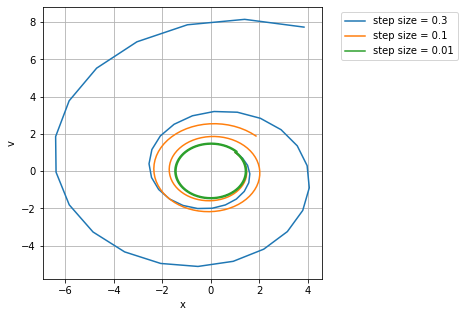

In [5]:
import numpy as np
x0 = 1
v0 = 1
def euler_method(step):
    t = np.arange(0.0, 4 * math.pi, step)
    x = x0
    v = v0
    xs = [x]
    vs = [v]
    for i in range(len(t)):
        nx = x + step * v
        nv = v - step * x
        x = nx
        v = nv
        xs.append(x)
        vs.append(v)
    return np.array(xs), np.array(vs)

x1, v1 = euler_method(0.3)
x2, v2 = euler_method(0.1)
x3, v3 = euler_method(0.01)

fig = plt.figure(figsize=(5, 5))
ax = plt.axes()
ax.plot(x1, v1, label = 'step size = 0.3')
ax.plot(x2, v2, label = 'step size = 0.1')
ax.plot(x3, v3, label = 'step size = 0.01')
ax.set(xlabel='x', ylabel='v')
ax.grid()
ax.legend(bbox_to_anchor=(1.05, 1))
plt.show()

You can see that, if we use a very crude step size (0.3), the simulation spirals out of the circle and is unstable. If we use a smaller step size it becomes better, but there is still a small error in the end.

Given an ODE and a solver, how can we analyze its behavior? Turns out that analyzing stability of non-linear ODEs is really really hard, so let's focus on linear ODEs first.

Given a linear ODE system:

$\dot{x} = Ax$

We can actually solve for the analytical solution (it's not a [closed form](https://en.wikipedia.org/wiki/Closed-form_expression) since in general we can't evaluate it in finite steps) using [matrix exponentials](https://en.wikipedia.org/wiki/Matrix_exponential):

$x = e^{At} x(0)$

where

$e^{At} = A + \frac{1}{2!} A^2 + \frac{1}{3!} A^3 + \cdots$

We won't go into the mathematical details here, see the super awesome [3Blue1Brown video](https://www.youtube.com/watch?v=O85OWBJ2ayo) for the intuition of this. 

My mental model of this is the following: if we discretize the equation above:
$x_{n+1} = (I+ \Delta_t A) x_n$, this means we are applying the matrix $(I + \Delta_t A)$ to our initial state repeatedly. If we take $\Delta_t$ to the limit, in scalar this is the definition of Euler number.

To analyze the limit behavior of $x$ above, let's first assume $A$ is [diagonalizable](https://en.wikipedia.org/wiki/Diagonalizable_matrix) (it turns out the result is exactly the same when $A$ is not diagonalizable, we just need to use the [Jordan normal form](https://en.wikipedia.org/wiki/Jordan_normal_form) of A). This means we can write $A$ as

$A = PDP^{-1}$

where $P$ is some invertible matrix and $D$ is a diagonal matrix with the elements of the eigenvalues $\lambda_i$ of $A$:

$
D
=
\begin{bmatrix}
 \lambda_0 & 0 & 0 & \cdots \\
 0 & \lambda_1 & 0 & \cdots \\
 0 & 0 & \lambda_2 & \cdots \\
 \cdots & \cdots & \cdots & \cdots
\end{bmatrix}
$

It's easy to show that

$
\exp(At) = P \exp(Dt) P^{-1} = 
P
\begin{bmatrix}
 e^{\lambda_0 t} & 0 & 0 & \cdots \\
 0 & e^{\lambda_1 t} & 0 & \cdots \\
 0 & 0 & e^{\lambda_2 t} & \cdots \\
 \cdots & \cdots & \cdots & \cdots
\end{bmatrix}
P^{-1}
$

Therefore, if the real part $A$'s eigenvalues are all negatives or zero (note that since $A$ can be asymmetric, its eigenvalues can be complex values), then $exp(At)$ is bounded, and thus the ODE $\dot{x} = Ax$ is stable.

Let's look at our three examples: for the first example we have

$A_1 = \begin{bmatrix}
 0 & 1 \\
-1 & 0
\end{bmatrix}$

The eigenvalues of $A_1$ are $i$ and $-i$. So the real parts of the eigenvalues are all zero. This means that $\dot{x} = A_1 x$ is stable but not attractive.

For the second example we have

$A_2 = \begin{bmatrix}
 0 & 1 \\
1 & 0
\end{bmatrix}$

and the eigenvalues are $-1$ and $1$. Note that even though one of the eigenvalues is negative, the limiting behavior is dominated by the eigenvalue with the largest real part. So $\dot{x} = A_2 x$ is not stable.

FInally, for the third example,

$A_3 = \begin{bmatrix}
 0 & 1 \\
-1 & -1
\end{bmatrix}$

the two eigenvalues are $-\frac{1}{2}+\frac{\sqrt{3}}{2}i$ and $-\frac{1}{2}-\frac{\sqrt{3}}{2}i$. The real parts are all strictly negative. This means that $\dot{x} = A_3 x$ is asymptotically stable.

So far we only talk about linear ODEs. For non-linear ODEs, there are two options for stability analysis: the first involves using the [Lyapunov function](https://en.wikipedia.org/wiki/Lyapunov_function). We won't get into the details of this however. We will use the other option: approximate the non-linear ODE $\dot{x} = f(x)$ using its Jacobian $J$: $\dot{x} \approx J(x_0) x$. 

# Stability analysis of the forward Euler method

Recall that the concept of the stability of an ODE, and the stability of the numerical ODE solvers are different. A stable ODE can have an unstable solver, and vice versa. However, the mathematics above are mostly directly applicable. Let's look at Euler method applied on a linear ODE $\dot{x} = Ax$:

$x_{n+1} = \left(I + \Delta_t A\right) x_{n}$

Therefore, $x_{n} = \left( I + \Delta_t A \right)^n x_{0} = B^n x_{0}$

We know that (again assuming $B=P_B D_B P_B^{-1}$ is diagonalizable):

$
B^n = P_B D_B^n P_B^{-1} = 
P_B
\begin{bmatrix}
 \lambda_{B, 0}^n & 0 & 0 & \cdots \\
 0 & \lambda_{B, 1}^n & 0 & \cdots \\
 0 & 0 & \lambda_{B, 2}^n & \cdots \\
 \cdots & \cdots & \cdots & \cdots
\end{bmatrix}
P^{-1}
$

Again, note that the eigenvalues $\lambda_{B, i}$ can be complex values. Furthermore, since $B = I + \Delta_t A$, $\lambda_{B,i} = 1 + \Delta_t \lambda_{A,i}$ where $\lambda_{A,i}$ is the eigenvalues of $A$. Therefore, if $|1 + \Delta_t \lambda_{A,i}| \leq 1$ (the absolute value is the magnitude of the complex value), the discretized ODE is stable. 

Let's apply this to our examples. For the first example $A_1$, recall that the eigenvalues are $i$ and $-i$, so the stability criteria are $|1 + \Delta_t i| \leq 1$ and $|1 - \Delta_t i| \leq 1$: it turns out that no $\Delta_t$ can statisfy these crtiera: Euler method can **never** be stable for our first example!!

For the third example $A_3$, the crtieria are 

$\left|1 + \Delta_t \left( -\frac{1}{2} + \frac{\sqrt{3}}{2} i \right) \right| \leq 1$

$\left|1 + \Delta_t \left( -\frac{1}{2} - \frac{\sqrt{3}}{2} i \right) \right| \leq 1$

With some algebra we can show that the criteria are equivalent to $\Delta_t \leq 1$. 

Let's try this!

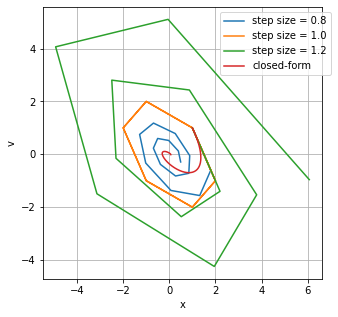

In [6]:
import numpy as np
x0 = 1
v0 = 1
def euler_method(step):
    t = np.arange(0.0, 4 * math.pi, step)
    x = x0
    v = v0
    xs = [x]
    vs = [v]
    for i in range(len(t)):
        nx = x + step * v
        nv = v + step * (-x - v)
        x = nx
        v = nv
        xs.append(x)
        vs.append(v)
    return np.array(xs), np.array(vs)

def x(x0, v0):
    tt = (math.sqrt(3) / 2) * t
    xt = np.exp(-t/2) * ((np.sqrt(3) / 3) * (x0 + 2 * v0) * np.sin(t) + x0 * np.cos(tt))
    vt = np.exp(-t/2) * (-(np.sqrt(3) / 3) * (2 * x0 + v0) * np.sin(t) + v0 * np.cos(tt))
    return xt, vt

x1, v1 = euler_method(0.8)
x2, v2 = euler_method(1.0)
x3, v3 = euler_method(1.2)

refx, refv = x(1, 1)

fig = plt.figure(figsize=(5, 5))
ax = plt.axes()
ax.plot(x1, v1, label = 'step size = 0.8')
ax.plot(x2, v2, label = 'step size = 1.0')
ax.plot(x3, v3, label = 'step size = 1.2')
ax.plot(refx, refv, label = 'closed-form')
ax.set(xlabel='x', ylabel='v')
ax.grid()
ax.legend(bbox_to_anchor=(1.05, 1))
plt.show()

As we can see, as soon as the step size becomes larger than $1$, the discretization becomes unstable and spirals out. Note that even though the other step sizes are stable, they are by no means accurate: they produce trajectories that are very different from the closed-form solution.

One more detail: as can be seen above, the stability of an ODE solver is related to the eigenvalues of the (linearized) continuous ODE. Matrices with large real parts of the eigenvalues are usually harder to discretize. We call these ODEs [stiff](https://en.wikipedia.org/wiki/Stiff_equation). 

# Stability analysis of the *backward* Euler method

How do we fix the stability problem of Euler method? The Euler method we have been using is called the forward method: given an ODE

$\dot{x} = f(x, t)$

The forward Euler method discretizes it as

$x_{n+1} = x_{n} + \Delta_t f(x_n, t_n)$

Note that we evaluate the function $f$ at position $x_n$. This causes us to have to *extrapolate* $f$ linearly from $x_n$ to $x_{n+1}$. Is there anyway to *interpolate* instead of extrapolate? The trick is to evaluate $f$ at $x_{n+1}$:

$x_{n+1} = x_{n} + \Delta_t f(x_{n+1}, t_{n+1})$

This may not makes sense at the first glance: if I know the value of $x_{n+1}$ given $x_{n}$, I don't need to integrate in the first place, why are you telling me to do this??

However, if we rearrange the equation a bit by gathering all terms with $x_{n+1}$ to the same side:

$x_{n+1} - \Delta_t f(x_{n+1}, t_{n+1}) = G(x_{n+1}, t_{n+1}, \Delta_t) = x_{n}$

We see that the left hand side is actually an *implicit* function $G$. So to get the values of $x_{n+1}$, we are finding the "roots" of function $G(x_{n+1}, t_{n+1}, \Delta_t) - x_n$. How do we find the roots depend on the exact ODEs we are solving, but in general we can apply some form of derivative-based optimization e.g., gradient descent, Newton's method, Gauss-Newton method, etc.

The implicit update equation above is called the [backward Euler method](https://en.wikipedia.org/wiki/Backward_Euler_method). This is one of the most commonly used time integrators in graphics. We will see why soon.

Let's apply the backwrad Euler method to our examples and see how it works. For our linear ODEs, $\dot{x} = Ax$, so the update equation above becomes

$(I - \Delta_t A) x_{n+1} = x_{n}$

In our case, since $A$ is a $2 \times 2$ matrix, there is a closed-form solution to the linear system above. In the general case, other linear system solvers might be needed. 

For a $2 \times 2$ matrix, the inverse of $I - \Delta_t A$ is

$
\frac{1}{A_{00} \Delta_t \left( A_{11} \Delta_t - 1 \right) - A_{01} A_{10} \Delta_t^2 - A_{11}\Delta_t + 1}
\begin{bmatrix}
1 - \Delta_t A_{11} & - \Delta_t A_{01} \\
-\Delta_t A_{10} & 1 - \Delta_t A_{00}
\end{bmatrix}
$

Let's try to apply the backward Euler method to our first example $\ddot{x} = -x$!

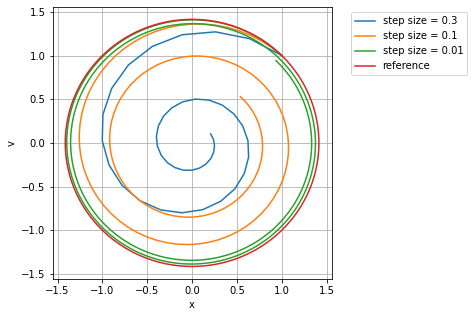

In [7]:
import numpy as np
x0 = 1
v0 = 1
def backward_euler_method(step):
    t = np.arange(0.0, 4 * math.pi, step)
    x = x0
    v = v0
    xs = [x]
    vs = [v]
    for i in range(len(t)):
        # A00 = 0, A01 = 1, A10 = -1, A11 = 0
        # The matrix is
        scalar = 1 / (step * step + 1)
        M00 = 1
        M01 = -step
        M10 = step
        M11 = 1
        nx = scalar * (M00 * x + M01 * v)
        nv = scalar * (M10 * x + M11 * v)
        x = nx
        v = nv
        xs.append(x)
        vs.append(v)
    return np.array(xs), np.array(vs)

x1, v1 = backward_euler_method(0.3)
x2, v2 = backward_euler_method(0.1)
x3, v3 = backward_euler_method(0.01)

t = np.arange(0.0, 2 * math.pi, 0.01)
# reference flow: x(0) = 1, v(0) = 1
refx = 1 * np.cos(t) + 1 * np.sin(t)
refv = 1 * np.cos(t) - 1 * np.sin(t)

fig = plt.figure(figsize=(5, 5))
ax = plt.axes()
ax.plot(x1, v1, label = 'step size = 0.3')
ax.plot(x2, v2, label = 'step size = 0.1')
ax.plot(x3, v3, label = 'step size = 0.01')
ax.plot(refx, refv, label = 'reference')
ax.set(xlabel='x', ylabel='v')
ax.grid()
ax.legend(bbox_to_anchor=(1.05, 1))
plt.show()

You can see that, unlike the forward Euler method, the backward Euler method spirals *inwards* and will not grow out of control (also note that it's not necessarily more accurate -- it is just more stable!). We can analyze the stability of backward Euler method for linear ODEs by noting that $x_{n+1} = \left( I - \Delta_t A \right)^{-1} x_n$ (compared to $x_{n+1} = \left( I - \Delta_t A \right) x_n$ in the forward Euler method case).

The eigenvalues of the matrix $\left( I - \Delta_t A \right)^{-1}$ are precisely the inverses of $\left( I - \Delta_t A \right)$. Therefore we can write their eigenvalues as $\frac{1}{1 + \Delta_t \lambda_{A, i}}$. The stability criteria become:

$\frac{1}{\left| 1 + \Delta_t \lambda_{A, i} \right|} \leq 1$

Notice that now the eigenvalues and timesteps are in the denominator: this makes achieving stability significantly easier. Let's look at our $A_1$ with eigenvalues $i$ and $-i$. The stability criteria are:

$\frac{1}{\left| 1 + \Delta_t i \right|} \leq 1$

$\frac{1}{\left| 1 - \Delta_t i \right|} \leq 1$

Both inequalities simplify to $\sqrt{1 + \Delta_t^2} \geq 1$: This means backward Euler method is **unconditionally stable** for this ODE, regardless of the step size!!

Too good to be true? Let's try to have large step sizes:

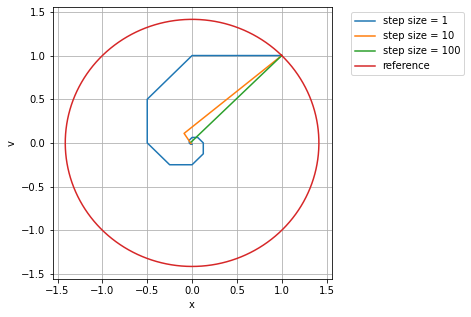

In [8]:
x4, v4 = backward_euler_method(1.0)
x5, v5 = backward_euler_method(10.0)
x6, v6 = backward_euler_method(100.0)

fig = plt.figure(figsize=(5, 5))
ax = plt.axes()
ax.plot(x4, v4, label = 'step size = 1')
ax.plot(x5, v5, label = 'step size = 10')
ax.plot(x6, v6, label = 'step size = 100')
ax.plot(refx, refv, label = 'reference')
ax.set(xlabel='x', ylabel='v')
ax.grid()
ax.legend(bbox_to_anchor=(1.05, 1))
plt.show()

You can see that there is no "magic": when the step size is very large, the object is immediately put to rest (in contrast to the "explosion" in the forward Euler method). In many applications this is the more desirable behavior: if there is going to be some error anyway, we want objects to stay put, instead of moving like it's crazy.

The cool thing about backward Euler is that for linear ODEs, you can actually prove that if the continuous ODE is already stable, then backward Euler is unconditionally stable. In practice, even fore non-linear ODEs, backward Euler is extremely stable for a wide range of timesteps.

The downside is that backward Euler is more computationally expensive. Remember we need to solve an implicit equation. For non-linear ODEs, this means that we often need to apply derivative-based optimization which is iterative. In graphics, a common hack is to truncate the iterative derivative-based optimization (e.g., we only apply one step of Newton's method). This introduces yet another source of discretization error, and is still more expensive than forward Euler, but in practice this can be made to work.

# Sympletic Euler method

For a particular kind of ODEs, it is actually possible to have an integrator that is as efficient as forward Euler, but as stable as backward Euler.

This class of integrators are called the ["sympletic integrators"](https://en.wikipedia.org/wiki/Symplectic_integrator). The naming has to do with some differential geometry concepts (see [sympletic manifolds](https://en.wikipedia.org/wiki/Symplectic_manifold)), but we won't get into this yet.

Recall that the sum of the energy of a closed physics system should be conserved. The sum of the energy is called a Hamiltonian $H = K + U$. Now, consider the following ODE:

$\dot{x} = \frac{\partial H(x, v)}{\partial v}$

$\dot{v} = -\frac{\partial H(x, v)}{\partial x}$

again, we won't get into detail about how this is derived, but it's called the Hamiltonian mechanics. Our first example $\ddot{x} = -x$ is Hamiltonian dynamics (with Hamiltonian $H = \frac{1}{2}v^2 + \frac{1}{2}x^2$). Also, in the general case the $v$ variable is the momentum, not the velocity. Here I assume the mass is $1$.

A cool thing about the Hamiltonian mechanics is that it preserves the **volume**: if we apply the dynamics for a region $R(0)$ of points ($x(0)$, $v (0)$), and map them to another region $R(T)$ , the volumes of the two regions in the $(x, v)$ space remain the same (this is known as [Liouville’s theorem](https://en.wikipedia.org/wiki/Liouville%27s_theorem_(Hamiltonian))). This volume preservation is what makes our first example going circles instead of converging or diverging.

However, both forward and backward Euler break the volume preservation, as we have seen earlier: forward Euler will spiral out and explodes in the limit, and backward Euler eventually will grind to the halt. Can we design an integrator that keeps going circle forever?

This is exactly what the sympletic integrators do. We'll introduce the simplest version called sympletic Euler. The update rule is as follows:

$v_{n+1} = v_n - \Delta_t \frac{\partial H(x_{n}, v_{n})}{\partial x}$

$x_{n+1} = x_n + \Delta_t \frac{\partial H(x_{n}, v_{n+1})}{\partial v}$

Notice in the second equation, we use $v_{n+1}$ to update the position $x$, instead of $v_n$. Before we explain why this preserves volume, let's run the code!

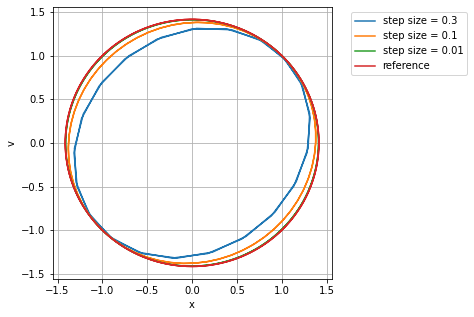

In [9]:
import numpy as np
x0 = 1
v0 = 1
def sympletic_euler_method(step):
    t = np.arange(0.0, 4 * math.pi, step)
    x = x0
    v = v0
    xs = [x]
    vs = [v]
    for i in range(len(t)):
        nv = v - step * x
        nx = x + step * nv
        x = nx
        v = nv
        xs.append(x)
        vs.append(v)
    return np.array(xs), np.array(vs)

x1, v1 = sympletic_euler_method(0.3)
x2, v2 = sympletic_euler_method(0.1)
x3, v3 = sympletic_euler_method(0.01)
# reference flow: x(0) = 1, v(0) = 1
t = np.arange(0.0, 4 * math.pi, 0.01)
refx = 1 * np.cos(t) + 1 * np.sin(t)
refv = 1 * np.cos(t) - 1 * np.sin(t)

fig = plt.figure(figsize=(5, 5))
ax = plt.axes()
ax.plot(x1, v1, label = 'step size = 0.3')
ax.plot(x2, v2, label = 'step size = 0.1')
ax.plot(x3, v3, label = 'step size = 0.01')
ax.plot(refx, refv, label = 'reference')
ax.set(xlabel='x', ylabel='v')
ax.grid()
ax.legend(bbox_to_anchor=(1.05, 1))
plt.show()

Notice that the simulatin neither spirals out nor spirals in! It will in fact just keep going in circle in theory (assuming accurate floating point operations). So, if your ODE looks like Hamiltonian dynamics, you should usually use a sympletic integrator to preserve its volume.

Why does sympletic Euler preserve volume? We can see this from the Jacobian of the update rule. Each update transforms the pair $x_n, v_n$ to the pair $x_{n+1}, v_{n+1}$. The Jacobian of the update rule above of this mapping has a triangular structure

$
\begin{bmatrix}
1 & 0 \\
\frac{\partial v_{n+1}}{\partial x_n} & 1
\end{bmatrix}
$

which leads to a unit determinant, therefore preserving the volume.

We might talk more about Hamiltonian dynamics and sympletic integrators in the future. They are super cool.

# Error analysis of ODE solvers

So far we only talked about stability. What about accuracy? Is there anyway for us to understand the errors of different methods. Fortunately, yes, and it's easier to explain compared to the stability concept (phew!). 

The trick we will use is Taylor expansion. For an ODE $\dot{x}(t) = f(x, t)$ with infinite differentiable $f$, we can expand around $x(t_n)$ and obtain:

$x(t_{n+1}) = x(t_n + \Delta_t) = x(t_n) + \Delta_t \dot{x}(t_n) + \frac{1}{2!} \Delta_t^2 \ddot{x}(t_n) + \cdots$

For forward Euler, we approximate $x(t_{n+1}) = x(t_n + \Delta_t) \approx x(t_n) + \Delta_t \dot{x}(t_n)$, so we know that the error is $O(\Delta_t^2)$. 

For backward Euler, we can use a different Taylor expansion around $x(t_{n+1})$:

$x(t_{n}) = x(t_{n+1} - \Delta_t) = x(t_{n+1}) - \Delta_t \dot{x}(t_{n+1}) + \frac{1}{2!} \Delta_t^2 \ddot{x}(t_n) + \cdots$

Rearranging the terms we get

$x(t_{n+1}) = x(t_{n}) + \Delta_t \dot{x}(t_{n+1}) - \frac{1}{2!} \Delta_t^2 \ddot{x}(t_n) + \cdots$

In backward Euler, we approximate $x(t_{n+1}) \approx x(t_{n}) + \Delta_t \dot{x}(t_{n+1})$ (by solving an implicit function to obtain $\dot{x}(t_{n+1})$), so we know that the error is also $O(\Delta_t^2)$.

Sympletic Euler also has the same error rate.

Can we do better? Of course! These Euler methods only approximate the function to the *first order* in terms of Taylor expansion. We can approximate more terms in the Taylor expansion. For example, consider the update rule:

$
x_{n+1} = x_{n} + \Delta_t \dot{x}_n + \frac{1}{2!} \Delta_t^2 \ddot{x}_n
$

this should be a more accurate than the previous Euler methods: the error rate is $O(\Delta_t^3)$.

However, this is computationally inconvienent: we don't want to maintain the second derivatives. Also, what if we want higher-order approximation? Still, this is a legitimate way to approximate ODEs and there are more efficient way to do this. See [this article](https://www.colorado.edu/amath/sites/default/files/attached-files/taylor_method_odes.pdf).

Instead, we'll introduce an alternative way, called the [Runge-Kutta methods](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods), to cancel out  Taylor expansion terms, by evaluating and expanding $x$ at different positions and time. For example, let's expand $x$ at $t_{n+0.5} = t_{n} + \frac{1}{2}\Delta_t$:

$
x(t_n) = x(t_{n+0.5} - \frac{1}{2}\Delta_t) = x(t_{n+0.5}) - \frac{\Delta_t}{2} \dot{x}(t_{n+0.5}) + \frac{1}{2!} \left(\frac{\Delta_t}{2}\right)^2 \ddot{x}(t_{n+0.5}) + \cdots \\
x(t_{n+1}) = x(t_{n+0.5} + \frac{1}{2}\Delta_t) = x(t_{n+0.5}) + \frac{\Delta_t}{2} \dot{x}(t_{n+0.5}) + \frac{1}{2!} \left(\frac{\Delta_t}{2}\right)^2 \ddot{x}(t_{n+0.5}) + \cdots
$

If we subtract the two, we cancel out the second order term and get

$
x(t_{n+1}) - x(t_n) = \Delta_t \dot{x}(t_{n+0.5}) + O(\Delta_t^3)
$

This leads to the following update (usually called the [midpoint method](https://en.wikipedia.org/wiki/Midpoint_method), but it is also a special case of Runge Kutta):

$
x_{n+0.5} = x_n + \frac{\Delta_t}{2} f(x_n, t_n) \\
x_{n+1} = x_{n} + \Delta_t f(x_{n+0.5}, t_n + \frac{\Delta_t}{2})
$

Notice that we first evaluate $f$ at $x_n, t_n$, then use the information to obtain an intermediate position $x_{n+0.5}$. We then obtain $x_{n+1}$ using the intermediate position. This has the rate of error of $O(\Delta_t^3)$. Let's try this out:

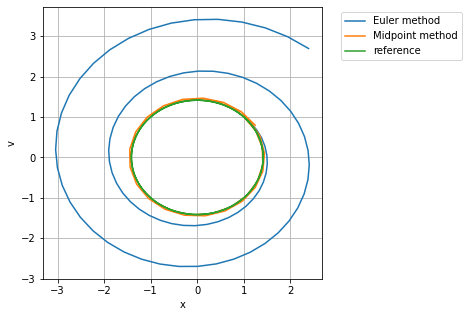

In [10]:
x0 = 1
v0 = 1
def euler_method(step):
    t = np.arange(0.0, 4 * math.pi, step)
    x = x0
    v = v0
    xs = [x]
    vs = [v]
    for i in range(len(t)):
        nx = x + step * v
        nv = v - step * x
        x = nx
        v = nv
        xs.append(x)
        vs.append(v)
    return np.array(xs), np.array(vs)

def midpoint_method(step):
    t = np.arange(0.0, 4 * math.pi, step)
    x = x0
    v = v0
    xs = [x]
    vs = [v]
    for i in range(len(t)):
        nx_half = x + 0.5 * step * v
        nv_half = v - 0.5 * step * x
        nx = x + step * nv_half
        nv = v - step * nx_half
        x = nx
        v = nv
        xs.append(x)
        vs.append(v)
    return np.array(xs), np.array(vs)

x1, v1 = euler_method(0.15)
x2, v2 = midpoint_method(0.3)
# reference flow: x(0) = 1, v(0) = 1
t = np.arange(0.0, 4 * math.pi, 0.01)
refx = 1 * np.cos(t) + 1 * np.sin(t)
refv = 1 * np.cos(t) - 1 * np.sin(t)

fig = plt.figure(figsize=(5, 5))
ax = plt.axes()
ax.plot(x1, v1, label = 'Euler method')
ax.plot(x2, v2, label = 'Midpoint method')
ax.plot(refx, refv, label = 'reference')
ax.set(xlabel='x', ylabel='v')
ax.grid()
ax.legend(bbox_to_anchor=(1.05, 1))
plt.show()

As you can see: even with a larger step size ($0.3$ vs $0.15$), the midpoint method almost matches the reference, while Euler method basically explodes. 

The similar trick can be used for implicit methods as well. Instead of looking at the midpoint, let's look at the Taylor expansions at $t_{n}$ for the primal value and the first derivative:

$
x(t_{n+1}) = x(t_{n} + \Delta_t) = x(t_{n}) + \Delta_t \dot{x}(t_{n}) + \frac{1}{2!} \Delta_t \ddot{x}(t_{n}) + \cdots \\
\dot{x}(t_{n+1}) = \dot{x}(t_{n} + \Delta_t) = \dot{x}(t_{n}) + \Delta_t \ddot{x}(t_{n}) + \frac{1}{2!} \Delta_t \dddot{x}(t_{n}) + \cdots
$

Notice that we can cancel the second order term:

$x(t_{n+1}) - \frac{\Delta_t}{2} \dot{x}(t_{n+1}) = x(t_n) + \frac{\Delta_t}{2} \dot{x}(t_n) + O(\Delta_t^3)$

Rearranging the terms we get the update rule called [trapezoidal rule](https://en.wikipedia.org/wiki/Trapezoidal_rule_(differential_equations)) with $O(\Delta_t^3)$ error.

$x_{n+1} = x_n + \frac{\Delta_t}{2}\left( f(x_n, t_n) + f(x_{n+1}, t_{n+1}) \right)$

As previous, $x_{n+1}$ appears on both sides, so we need to solve for the roots. For the linear ODEs $f(x, t) = Ax$ we get

$x_{n+1} = \left(I - \frac{\Delta_t}{2} A\right)^{-1} (I + \frac{\Delta_t}{2} A) x_n$

Let's see this in action!

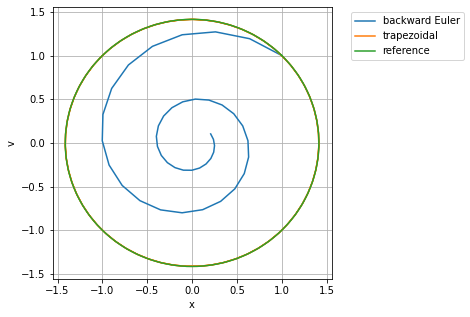

In [11]:
x0 = 1
v0 = 1
def backward_euler_method(step):
    t = np.arange(0.0, 4 * math.pi, step)
    x = x0
    v = v0
    xs = [x]
    vs = [v]
    for i in range(len(t)):
        # A00 = 0, A01 = 1, A10 = -1, A11 = 0
        # The matrix is
        scalar = 1 / (step * step + 1)
        M00 = 1
        M01 = -step
        M10 = step
        M11 = 1
        nx = scalar * (M00 * x + M01 * v)
        nv = scalar * (M10 * x + M11 * v)
        x = nx
        v = nv
        xs.append(x)
        vs.append(v)
    return np.array(xs), np.array(vs)

def trapezoidal_method(step):
    t = np.arange(0.0, 4 * math.pi, step)
    x = x0
    v = v0
    xs = [x]
    vs = [v]
    for i in range(len(t)):
        A = np.array([[0.0, 1.0], [-1.0, 0.0]])
        M = np.linalg.inv(np.eye(2) - (step / 2) * A) @ (np.eye(2) + (step / 2) * A)
        next = M @ np.array([x, v])
        x = next[0]
        v = next[1]
        xs.append(x)
        vs.append(v)
    return np.array(xs), np.array(vs)

x1, v1 = backward_euler_method(0.3)
x2, v2 = trapezoidal_method(0.1)

t = np.arange(0.0, 2 * math.pi, 0.01)
# reference flow: x(0) = 1, v(0) = 1
refx = 1 * np.cos(t) + 1 * np.sin(t)
refv = 1 * np.cos(t) - 1 * np.sin(t)

fig = plt.figure(figsize=(5, 5))
ax = plt.axes()
ax.plot(x1, v1, label = 'backward Euler')
ax.plot(x2, v2, label = 'trapezoidal')
ax.plot(refx, refv, label = 'reference')
ax.set(xlabel='x', ylabel='v')
ax.grid()
ax.legend(bbox_to_anchor=(1.05, 1))
plt.show()

Super accurate!

With the same principle, we can actually do even better. This tour is starting to get too long, so I won't get into the detail derivation here, but Runge Kutta methods are a full class of explicit and implicit integrators that cancel out different number of terms in the Taylor expansion. For example, the following update rule, usually called RK4 (because it cancels out Taylor expansion terms up to the fourth derivative), has an error rate of $O(\Delta_t^5)$!

$
k_0 = f(x_n, t_n) \\
k_1 = f(x_n + \frac{\Delta_t}{2} k_0, t_n + \frac{\Delta_t}{2}) \\
k_2 = f(x_n + \frac{\Delta_t}{2} k_1, t_n + \frac{\Delta_t}{2}) \\
k_3 = f(x_n + \Delta_t k_2, t_n + \Delta_t) \\
x_{n+1} = x_{n} + \frac{1}{6}\left(k_0 + 2 k_1 + 2 k_2 + k_3\right)
$

(exercise: implement this!)

That's it for now. We actually only scratched the surface of possible time integrator design, and there are a lot of fun techniques to explore in the future. However, the basic principles are similar: it's always about trade-offs between accuracy, efficiency, and stability. In general, forward/explicit methods are fast but not very stable. Backward/implicit methods are slower but stable. Higher-order methods are accurate, but less efficient. Importantly, having knowledge of your ODEs can often lead to more efficient integrators that *preserve the high-level structures of the ODEs*, like the sympletic integrators preserving the volumes.

There wasn't a lot of animations this time. I promise next time we will have a bunch of time. We will look into deforming objects next, by generalizing the Hooke's law we investigate this time.